# Robustness analysis

## Import and Reading Results from Open Exploration

In [23]:
# Importing external packages

import os
import sys
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
import math
import seaborn as sns
import pandas as pd
import numpy as np
import statistics
from collections import defaultdict
from tqdm import tqdm
from pandas.plotting import parallel_coordinates
from matplotlib.lines import Line2D
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import dimensional_stacking
from sklearn.preprocessing import MinMaxScaler
from plotter import plot_robustness_parallel
from plotter import plot_robustness_parallel2
import importlib
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [18]:
# Importing model scripts, by first adding the main folder path

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from model.model_nile import ModelNile
from experimentation.data_generation import generate_input_data
import plotter

import matplotlib
import matplotlib.font_manager as fm

# sns.set(font_scale=1.2)

fm.fontManager.addfont("Minion Pro Regular.ttf")
matplotlib.rc("font", family="Minion Pro")

from matplotlib import rcParams

rcParams["font.family"] = "Minion Pro"
rcParams["font.sans-serif"] = "Minion Pro"
rcParams["font.size"] = 12

Read the results of the open exploration:

In [19]:
experiments = pd.read_csv("../outputs/experiments_exploration.csv").drop(
    columns="Unnamed: 0"
)
outcomes = pd.read_csv("../outputs/outcomes_exploration.csv").drop(columns="Unnamed: 0")

In [20]:
policy_name_conversion = {
    "best_egypt_aggregate": "Best Egypt Irr.",
    "best_egypt_HAD": "Best Egypt HAD",
    "best_sudan_aggregate": "Best Sudan Irr.",
    "best_ethiopia": "Best Ethiopia Hydropower",
    "compromise_percentile": "Compromise: Percentile",
    "compromise_threshold": "Compromise: Absolute",
}
for i in tqdm(experiments.index):
    experiments.loc[i, "policy"] = policy_name_conversion[experiments.loc[i, "policy"]]

outcomes["policy"] = experiments["policy"]
outcomes["scenario"] = experiments["scenario"]

100%|██████████| 30000/30000 [00:08<00:00, 3609.70it/s]


In [21]:
outcomes.describe()

,egypt_irr,egypt_low_had,sudan_irr,ethiopia_hydro,scenario
count,30000.00,30000.00,30000.00,30000.00,30000.00
mean,7.60,0.39,1.21,13.17,2499.50
std,5.90,0.38,1.21,2.93,1443.40
min,0.01,0.00,0.00,7.87,0.00
25%,2.75,0.00,0.16,10.71,1249.75
50%,6.34,0.27,0.78,13.03,2499.50
75%,11.26,0.80,2.10,15.63,3749.25
max,33.66,0.93,4.70,19.30,4999.00


## Sensitivity Analysis

In [6]:
# All the factors for global sensitivity analysis in the same dataframe:
experiments.iloc[:, [0, 1, 2, 3, 4, 5, 6, -2]]

,atbara_dev_coef,atbara_mean_coef,blue_nile_dev_coef,blue_nile_mean_coef,white_nile_dev_coef,white_nile_mean_coef,yearly_demand_growth_rate,policy
0,1.094245,0.855992,0.523482,0.976537,0.970430,0.805161,0.015250,Best Egypt Irr.
1,1.069875,1.066646,1.018600,1.215645,1.175533,0.901954,0.016133,Best Egypt Irr.
2,1.174271,1.047017,1.266086,0.774602,1.225615,1.042462,0.027328,Best Egypt Irr.
3,1.195377,0.761595,0.566289,0.910644,0.569191,0.992986,0.019779,Best Egypt Irr.
4,0.608448,0.832934,0.737053,0.905520,1.327775,0.824752,0.025875,Best Egypt Irr.
...,...,...,...,...,...,...,...,...
29995,0.931688,0.864760,0.845082,1.072397,1.122069,1.178797,0.027055,Compromise: Absolute
29996,0.653069,1.105000,1.120084,1.133356,0.938552,0.941043,0.010112,Compromise: Absolute
29997,1.394813,0.755644,0.536670,1.102401,0.508935,1.090423,0.028869,Compromise: Absolute
29998,1.451985,1.119426,1.058518,1.225369,1.459470,0.851562,0.018764,Compromise: Absolute


In [7]:
# OOIs must be prepared as a dict with name in key and np arrays in value for the feature scoring:

out_dict = dict()
for col in outcomes.iloc[:, :-2].columns:
    out_dict[col] = np.array(outcomes[col])

np.random.seed(123)

scores = feature_scoring.get_feature_scores_all(
    experiments.iloc[:, [0, 1, 2, 3, 4, 5, 6, -2]], out_dict, nr_trees=1000
)
scores

,egypt_irr,egypt_low_had,sudan_irr,ethiopia_hydro
0,,,,
atbara_dev_coef,0.005535,0.006386,0.002926,0.003248
atbara_mean_coef,0.012894,0.040191,0.004227,0.003945
blue_nile_dev_coef,0.005327,0.006641,0.003045,0.003110
blue_nile_mean_coef,0.126597,0.603943,0.309610,0.802772
policy,0.183772,0.099617,0.600167,0.172041
white_nile_dev_coef,0.005415,0.006491,0.002772,0.002960
white_nile_mean_coef,0.067350,0.217720,0.011538,0.008335
yearly_demand_growth_rate,0.593109,0.019011,0.065714,0.003588


In [8]:
# Put the feature scores in desired order:
scores = scores.iloc[[4, 0, 1, 2, 3, 5, 6, 7]]

# Do some formatting and use pandas.style to color-code the feature scores table:
pd.set_option("display.float_format", "{:.2f}".format)
pd.options.display.precision = 2

scores.columns = [
    "Egypt Irr. Deficit",
    "Egypt Low HAD",
    "Sudan Irr. Deficit",
    "Ethiopia Hydropower",
]

scores = scores.set_index(
    pd.Series(
        [
            "Policy",
            "Atbara Deviation",
            "Atbara Mean",
            "Blue Nile Deviation",
            "Blue Nile Mean",
            "White Nile Deviation",
            "White Nile Mean",
            "Demand Growth",
        ]
    )
)
scores.index.name = None


In [9]:
cell = {  # for row hover use <tr> instead of <td>
    "selector": "td",
    "props": [
        ("font-family", "Minion Pro"),
        ("font-size", "11pt"),
        ("text-align", "center"),
    ],
}
index_names = {
    "selector": ".index_name",
    "props": "font-family: Minion Pro; font-size: 10.5pt; background-color: white; text-align: center",
}
headers = {
    "selector": "th:not(.index_name)",
    "props": "font-family: Minion Pro; font-size: 10.5pt; background-color: black; text-align: center",
}

styled_df = scores.style.background_gradient(cmap="Blues", axis=None).set_table_styles(
    [cell, index_names, headers]
)
styled_df

,Egypt Irr. Deficit,Egypt Low HAD,Sudan Irr. Deficit,Ethiopia Hydropower
Policy,0.183772,0.099617,0.600167,0.172041
Atbara Deviation,0.005535,0.006386,0.002926,0.003248
Atbara Mean,0.012894,0.040191,0.004227,0.003945
Blue Nile Deviation,0.005327,0.006641,0.003045,0.003110
Blue Nile Mean,0.126597,0.603943,0.309610,0.802772
White Nile Deviation,0.005415,0.006491,0.002772,0.002960
White Nile Mean,0.067350,0.217720,0.011538,0.008335
Demand Growth,0.593109,0.019011,0.065714,0.003588


In [10]:
styled_df.to_excel("../plots/tables/styled_sensitivity.xlsx")

## Robustness Calculation Across Solutions

Our ambition is to calculate the robustness scores of each solutions with 5,000 alternative SOWs each, using four robustness metrics.

In [11]:
# All the factors for robustness analysis in the same dataframe:
outcomes.iloc[:, [0, 1, 2, 3, 4]]

,egypt_irr,egypt_low_had,sudan_irr,ethiopia_hydro,policy
0,3.73,0.82,2.54,10.95,Best Egypt Irr.
1,1.52,0.00,0.69,15.76,Best Egypt Irr.
2,14.52,0.83,3.85,8.28,Best Egypt Irr.
3,5.33,0.80,2.94,9.81,Best Egypt Irr.
4,14.89,0.85,3.65,9.80,Best Egypt Irr.
...,...,...,...,...,...
29995,11.13,0.00,0.22,15.23,Compromise: Absolute
29996,0.72,0.00,0.19,16.34,Compromise: Absolute
29997,12.81,0.00,0.21,15.63,Compromise: Absolute
29998,4.10,0.00,0.14,17.92,Compromise: Absolute


## 90th Percentile Regret

In [12]:
overall_regret = {}
max_regret = {}
max90_regret = {}
directions = ["min", "min", "min", "max"]

for i, outcome in enumerate(outcomes.columns[:4]):
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
    data = data.pivot(index="scenario", columns="policy")
    data.columns = data.columns.get_level_values(1)

    if directions[i] == "min":
        outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
    else:
        outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()

    overall_regret[outcome] = outcome_regret
    max_regret[outcome] = outcome_regret.max()
    max90_regret[outcome] = outcome_regret.quantile(
        0.9, axis=0, interpolation="nearest"
    )

max90_regret_scores = pd.DataFrame.from_dict(max90_regret)
max90_regret_scores.index.name = "policy"
max90_regret_scores

,egypt_irr,egypt_low_had,sudan_irr,ethiopia_hydro
policy,,,,
Best Egypt HAD,1.53,0.00,3.85,3.96
Best Egypt Irr.,0.99,0.46,3.76,4.24
Best Ethiopia Hydropower,11.87,0.80,1.56,0.00
Best Sudan Irr.,4.09,0.51,0.00,3.21
Compromise: Absolute,2.60,0.23,2.35,1.32
Compromise: Percentile,3.23,0.20,1.56,1.33


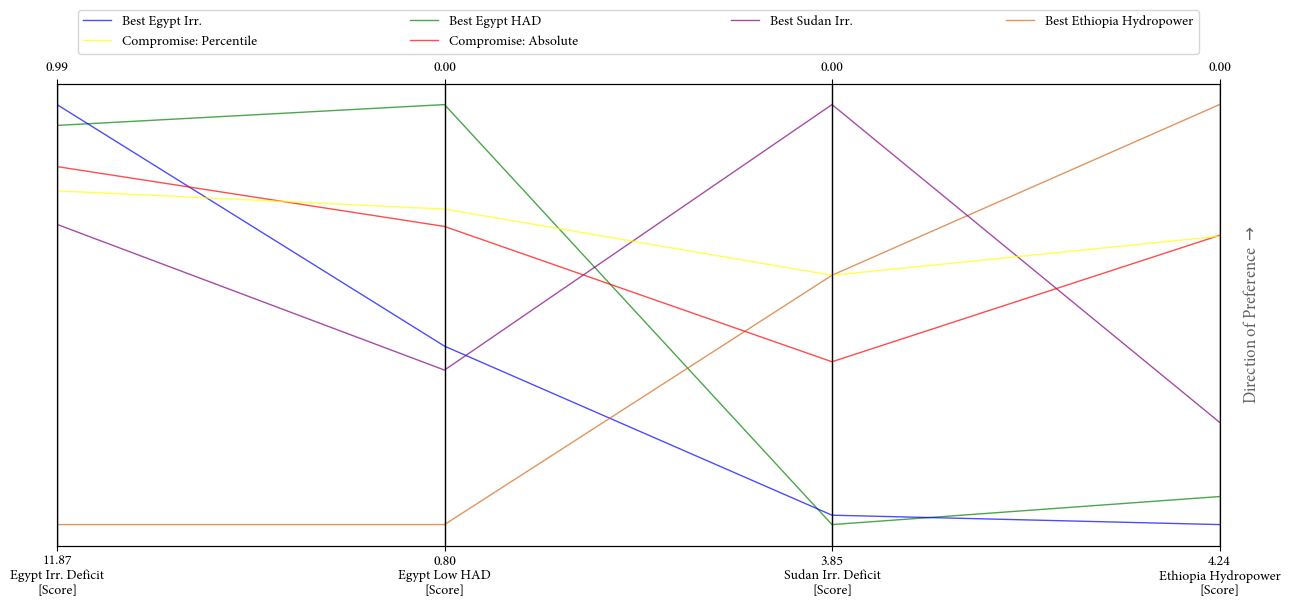

Finished plotting


In [13]:
plot_robustness_parallel(max90_regret_scores, metric_type="90th_percentile")

## Minimax Regret

In [14]:
overall_regret = {}
directions = ["min", "min", "min", "max"]


for i, outcome in enumerate(outcomes.columns[:4]):
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
    data = data.pivot(index="scenario", columns="policy")
    data.columns = data.columns.get_level_values(1)

    if directions[i] == "min":
        outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
    else:
        outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()

    overall_regret[outcome] = outcome_regret

minimax_regret = {}
for outcome in outcomes.columns[:4]:
    outcome_regret = overall_regret[outcome]
    minimax_regret[outcome] = outcome_regret.max(axis=0)

minimax_regret_scores = pd.DataFrame.from_dict(minimax_regret)
minimax_regret_scores.index.name = "policy"
minimax_regret_scores


,egypt_irr,egypt_low_had,sudan_irr,ethiopia_hydro
policy,,,,
Best Egypt HAD,2.79,0.03,4.54,4.23
Best Egypt Irr.,1.45,0.75,4.52,4.47
Best Ethiopia Hydropower,12.79,0.86,2.44,0.00
Best Sudan Irr.,4.99,0.72,0.00,3.42
Compromise: Absolute,3.80,0.52,4.03,1.50
Compromise: Percentile,4.38,0.48,3.41,1.71


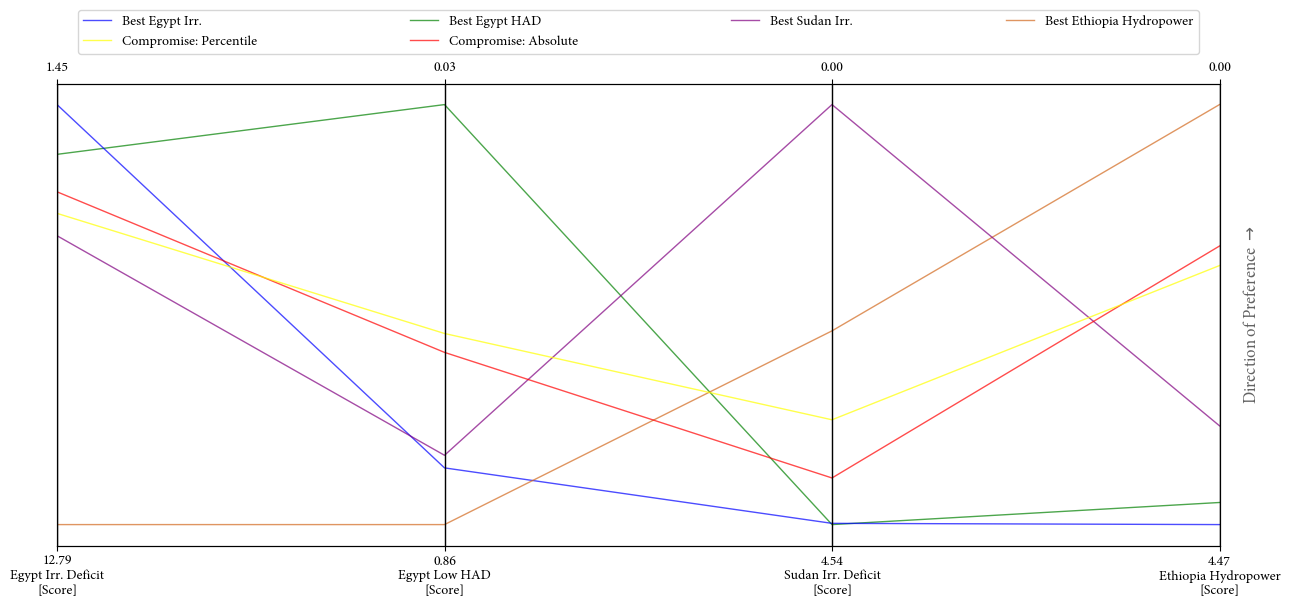

Finished plotting


In [22]:
plotter.plot_robustness_parallel(minimax_regret_scores, metric_type="minimax")

## Undesirable Deviation

In [15]:
undesirable_deviations = {}
directions = ["min", "min", "min", "max"]

for i, outcome in enumerate(outcomes.columns[:4]):
    data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
    data = data.pivot(index="scenario", columns="policy")
    data.columns = data.columns.get_level_values(1)

    q50 = data.median(axis=0)

    if directions[i] == "min":
        deviations = ((data - q50)**2).where(data > q50, 0).sum(axis=0)
    else:
        deviations = ((data - q50)**2).where(data < q50, 0).sum(axis=0)

    undesirable_deviations[outcome] = deviations

undesirable_deviations_scores = pd.DataFrame.from_dict(undesirable_deviations)
undesirable_deviations_scores.index.name = "policy"
undesirable_deviations_scores

,egypt_irr,egypt_low_had,sudan_irr,ethiopia_hydro
policy,,,,
Best Egypt HAD,91631.99,971.63,2695.70,12704.87
Best Egypt Irr.,94634.69,486.27,2325.80,9019.21
Best Ethiopia Hydropower,146080.64,6.61,1083.89,15133.70
Best Sudan Irr.,115002.55,438.52,13.10,10867.07
Compromise: Absolute,108564.51,1019.17,4095.77,15196.45
Compromise: Percentile,112331.78,1059.16,2483.09,16698.42


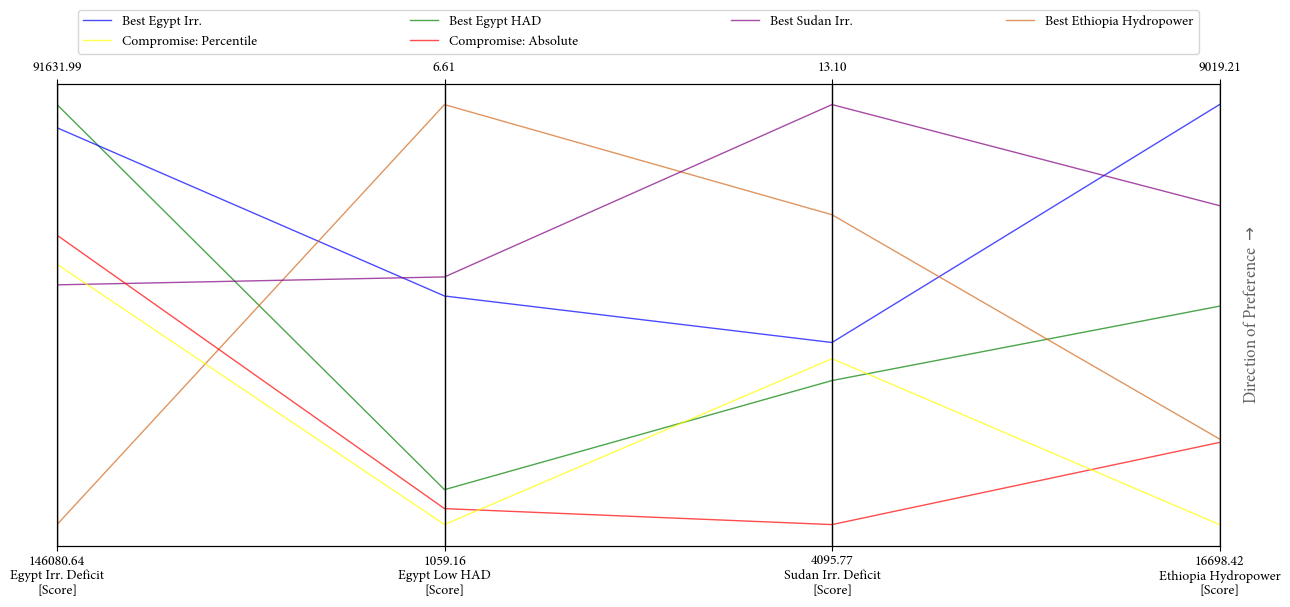

Finished plotting


In [24]:
plotter.plot_robustness_parallel(undesirable_deviations_scores, metric_type="undesirable_deviations")

## Percentile Based Skewness

In [28]:
def calculate_percentile_based_skewness(outcomes, directions):
    percentile_skewness = {}
    
    for i, outcome in enumerate(outcomes.columns[:4]):
        data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
        data = data.pivot(index="scenario", columns="policy")
        data.columns = data.columns.get_level_values(1)
        
        q10 = data.quantile(0.1, axis=0)
        q50 = data.quantile(0.5, axis=0)
        q90 = data.quantile(0.9, axis=0)
        
        skewness = ((q90 + q10) / 2 - q50) / ((q90 - q10) / 2)
        
        if directions[i] == "min":
            percentile_skewness[outcome] = -skewness
        else:
            percentile_skewness[outcome] = skewness
    
    percentile_skewness_scores = pd.DataFrame.from_dict(percentile_skewness)
    percentile_skewness_scores.index.name = "policy"
    return percentile_skewness_scores

# Directions for calculating percentile-based skewness
directions = ["min", "min", "min", "max"]

percentile_skewness_scores = calculate_percentile_based_skewness(outcomes, directions)
percentile_skewness_scores

,egypt_irr,egypt_low_had,sudan_irr,ethiopia_hydro
policy,,,,
Best Egypt HAD,-0.32,-1.00,0.18,0.21
Best Egypt Irr.,-0.32,-0.20,0.14,0.27
Best Ethiopia Hydropower,-0.14,0.86,-0.33,-0.01
Best Sudan Irr.,-0.27,-0.14,-0.99,0.28
Compromise: Absolute,-0.32,-0.81,-0.52,0.04
Compromise: Percentile,-0.28,-0.87,-0.71,0.01


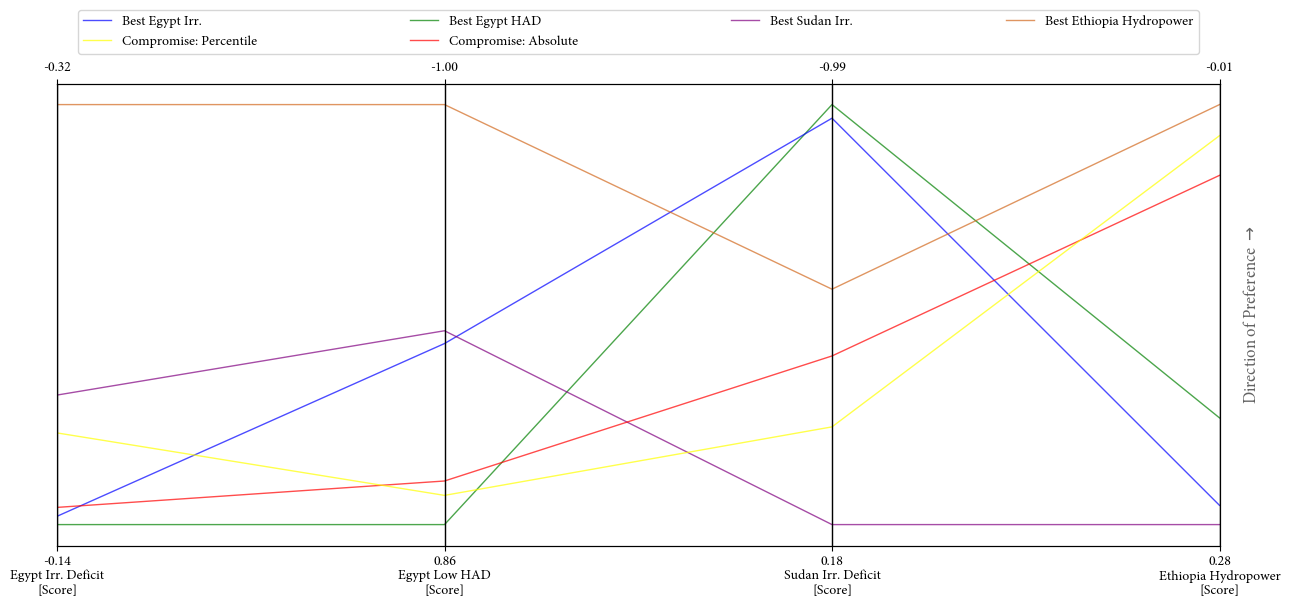

Finished plotting


In [30]:
plot_robustness_parallel2(percentile_skewness_scores, "percentile_skewness", directions)

## Mean Variance


In [31]:
directions = ["min", "min", "min", "max"]

def calculate_mean_variance_robustness(outcomes, directions):
    mean_variance = {}
    
    for i, outcome in enumerate(outcomes.columns[:4]):
        data = outcomes.loc[:, [outcome, "policy", "scenario"]].copy()
        data = data.pivot(index="scenario", columns="policy")
        data.columns = data.columns.get_level_values(1)
        
        mean = data.mean(axis=0)
        std_dev = data.std(axis=0)
        
        if directions[i] == "min":
            mean_variance[outcome] = mean * std_dev
        else:
            mean_variance[outcome] = mean / std_dev
    
    mean_variance_scores = pd.DataFrame.from_dict(mean_variance)
    mean_variance_scores.index.name = "policy"
    return mean_variance_scores

mean_variance_scores = calculate_mean_variance_robustness(outcomes, directions)
mean_variance_scores


,egypt_irr,egypt_low_had,sudan_irr,ethiopia_hydro
policy,,,,
Best Egypt HAD,26.00,0.09,2.86,4.27
Best Egypt Irr.,25.19,0.15,2.65,4.51
Best Ethiopia Hydropower,87.33,0.22,0.45,6.18
Best Sudan Irr.,40.78,0.15,0.00,4.28
Compromise: Absolute,33.51,0.13,0.91,5.45
Compromise: Percentile,37.30,0.12,0.41,5.35


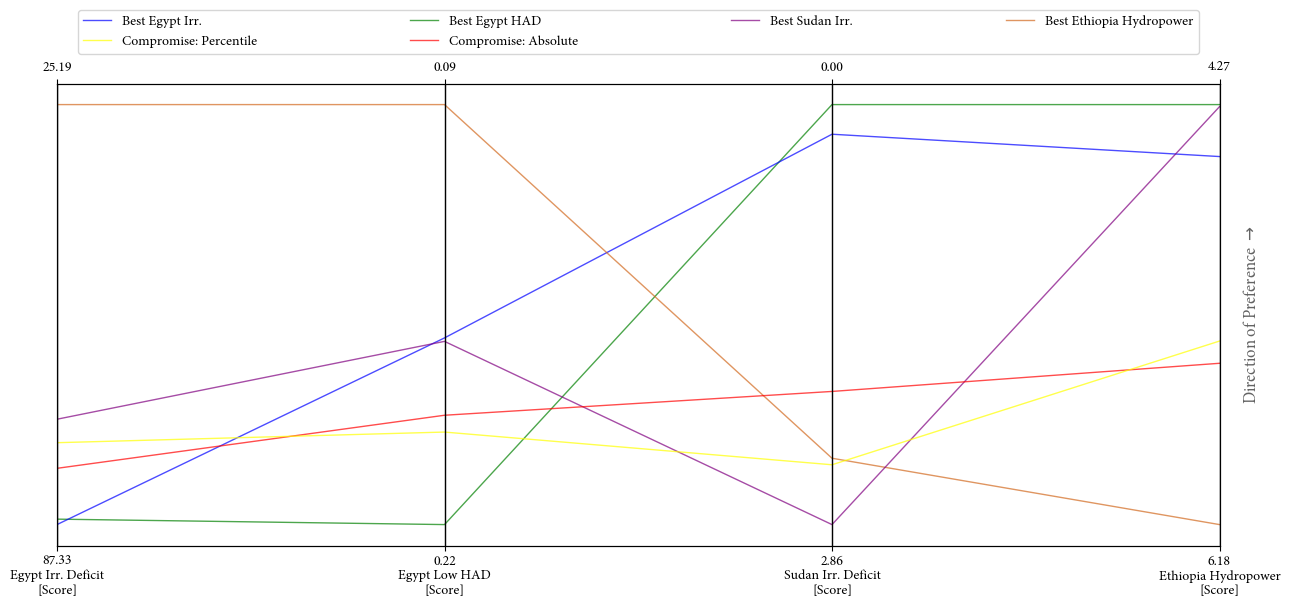

Finished plotting


In [32]:
plot_robustness_parallel2(mean_variance_scores, "mean_variance", directions)